In [1]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import copy

import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd


from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import target_visual_field as targ
from pipeline.python.retinotopy import utils as rutils


from matplotlib.patches import Ellipse, Rectangle

pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema

In [2]:
%matplotlib notebook

In [3]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    try:
        for cyc_ix, cyc_start in enumerate(cycle_starts):

            curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
            curr_values = avg_cycle_c1[curr_frames]
            cmax = int(np.where(curr_values==curr_values.max())[0][0])
            startix = 0
            if cmax == 0:
                while cmax < (fr_per_cyc / len(cycle_starts)): #4:
                    print "Getting new cmax..."
                    cmax = int(np.where(curr_values[startix:]==curr_values[startix:].max())[0][0])
                    startix += 1
                cmax = cmax + startix
            #elif (cmax - cmaxima[-1]) < (fr_per_cyc/2):
                
            cmaxima.append((curr_frames[cmax], curr_values.max()))

            minval = curr_values[startix:cmax].min()
            cmin = int(np.where(curr_values[startix:cmax]==minval)[0][0]) + startix
            cminima.append((curr_frames[cmin], minval))

            baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
            bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
            if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
                if cyc_ix == 0:
                    # No previous cycle to borrow frames from
                    bindices = curr_frames[0:cmin+baseline_window_size]
                    baseline = curr_values[0:cmin+baseline_window_size]
                else:
                    prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                    prev_values = avg_cycle_c1[prev_frames]
                    nprev = baseline_window_size-cmin
                    bindices = curr_frames[0:cmin] #+baseline_window_size]
                    bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                    baseline = prev_values[-nprev:]
                    baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

            thr_value = baseline.mean() + (baseline.std() * nstds_above_baseline) #curr_values.max()*0.1
            onset = np.where(np.abs(curr_values[cmin:cmax]-thr_value)\
                             ==np.min(np.abs(curr_values[cmin:cmax]-thr_value)))[0] + cmin # Only look b/w max/min 

            onsets.append((curr_frames[onset], curr_values[onset]))
            baseline_values.append(baseline)
            baseline_indices.append(bindices)
    except Exception as e:
        return None
        
    loci = {'maxima': cmaxima,
           'minima': cminima,
           'onsets': onsets,
           'baseline_indices': baseline_indices,
           'baseline_values': baseline_values,
           'nstds_above_baseline': nstds_above_baseline}
        
    return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)

        
        

In [4]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

# Select dataset

In [5]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC073', '-S', '20190322', '-R', 'retino_run1', '-A', 'FOV1']
#options = ['-i', 'JC073', '-S', '20190327', '-R', 'retino_run2', '-A', 'FOV1']

In [6]:
opts = rutils.extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load dataset

In [7]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = rutils.load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', 'parsed_trials*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)

# Get stimulus info:
stiminfo = rutils.get_retino_stimulus_info(mwinfo, runinfo)


FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.


In [8]:
# Get FFT results and format
print "-----------------------------------"
print "Getting formatted FFT analysis"
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)
print "---------------------------------"
print "Trials by condN:", trials_by_cond


print "-----------------------------------"
print "Getting MW info (stimulus positions)"
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = rutils.get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

print "Stimulus conditions (bar start/end):"
for cond in stim_positions.keys():
    print '--- %s: [%.2f, %.2f]' %(cond, stim_positions[cond].iloc[0,:].mean(), stim_positions[cond].iloc[-1,:].mean())

print "-----------------------------------"
print "Getting screen info"
screen_info = visroi.get_screen_info(animalid, session, fov=fov.split('_')[0], interactive=True, rootdir=rootdir)

left_edge = stim_positions['left'].mean(axis=1).iloc[0]
right_edge = stim_positions['right'].mean(axis=1).iloc[0]
top_edge = stim_positions['top'].mean(axis=1).iloc[0]
bottom_edge = stim_positions['bottom'].mean(axis=1).iloc[0]
print "L/R edges:", left_edge, right_edge
print "B/T edges:", bottom_edge, top_edge


-----------------------------------
Getting formatted FFT analysis
TRIALS BY COND:
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_data_FOV1_retino_Slice01_Channel01_File005.h5
6: retino_data_FOV1_retino_Slice01_Channel01_File006.h5
7: retino_data_FOV1_retino_Slice01_Channel01_File007.h5
8: retino_data_FOV1_retino_Slice01_Channel01_File008.h5
9: retino_data_FOV1_retino_Slice01_Channel01_File009.h5
10: retino_data_FOV1_retino_Slice01_Channel01_File010.h5
11: retino_data_FOV1_retino_Slice01_Channel01_File011.h5
12: retino_data_FOV1_retino_Slice01_Channel01_File012.h5
---------------------------------
Trials by condN: {u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2

In [9]:

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print 'Extracted retino traces contains:' 
print '---', extr_traces.keys()
print 'Each parsed file contains:'
print "--- ---", extr_traces[extr_traces.keys()[0]].keys()

print "---------------------------------"
print "Current retino run: %s" % run
print "---------------------------------"
for param in stiminfo['right'].keys():
    if param == 'cycle_start_ixs' or param == 'frame_tstamps': continue
    print param, ':', stiminfo['right'][param]

Extracted retino traces contains:
--- [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
Each parsed file contains:
--- --- [u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
---------------------------------
Current retino run: retino_run1
---------------------------------
trials_by_,cond : {u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
n_cycles : 12
stimfreq : 0.13
frame_rate : 44.6329
n_reps : 3
n_frames_per_cycle : 343
nframes : 4125


# Select top cells for fits

In [10]:
# Also get mean magratios:
mean_magratios = pd.concat([pd.Series(magratio[trialnums].mean(axis=1), name=cond) \
                            for cond, trialnums in trials_by_cond.items()], axis=1)

In [11]:
mag_thr = magratio.mean(axis=1).max() * 0.5 #0.02

mag_thr_stat = 'allconds'
mag_thr = magratio.mean(axis=1).max() * 0.3 #0.02
use_fit = False


print "-----------------------------------"

print "Filtering ROIs by strongest mag-ratios."
top_rois = rutils.select_rois(mean_magratios, mag_thr=mag_thr, mag_thr_stat=mag_thr_stat)

print "Strongest cells (n=%i, mag-ratio >= %.2f):" % (len(top_rois), mag_thr)
print top_rois                   
print "-----------------------------------"

sorted_rois = np.argsort(mean_magratios.max(axis=1))[::-1].values
sorted_top_roi_ixs = np.argsort(mean_magratios.max(axis=1)[top_rois])[::-1].values
sorted_top_rois = np.array([top_rois[ix] for ix in sorted_top_roi_ixs])
print "Total %i of %i rois" % (len(sorted_top_rois), len(sorted_rois))
print sorted_top_rois
print "----- best -----"
for r in sorted_top_rois[0:5]:
    print r, mean_magratios.max(axis=1)[r]
print "----- worst -----"
for r in sorted_top_rois[-5:]:
    print r, mean_magratios.max(axis=1)[r]
    

-----------------------------------
Filtering ROIs by strongest mag-ratios.
Strongest cells (n=22, mag-ratio >= 0.02):
[  3   5  13  19  26  27  28  34  36  37  42  46  53  55  63  65  77  80
  83  97 100 107]
-----------------------------------
Total 22 of 108 rois
[ 37  55   3  42  28  27  77  36  80  63  26  83  53  46  19  97  13 107
  34  65   5 100]
----- best -----
37 0.105197713844
55 0.0777084414023
3 0.072648281175
42 0.06921431672
28 0.067422536766
----- worst -----
107 0.0389862459193
34 0.0385902325084
65 0.0385013242417
5 0.0306689257198
100 0.0290442880858


In [12]:
#### Look at 1 roi to find peak, fit gaussian

In [13]:
rid = 80
print "RID: %i" % rid

roi_traces= dict()
for condition in trials_by_cond.keys():
    roi_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
    #print"%s:" % condition, tmp_traces[condition].shape


RID: 80


<IPython.core.display.Javascript object>


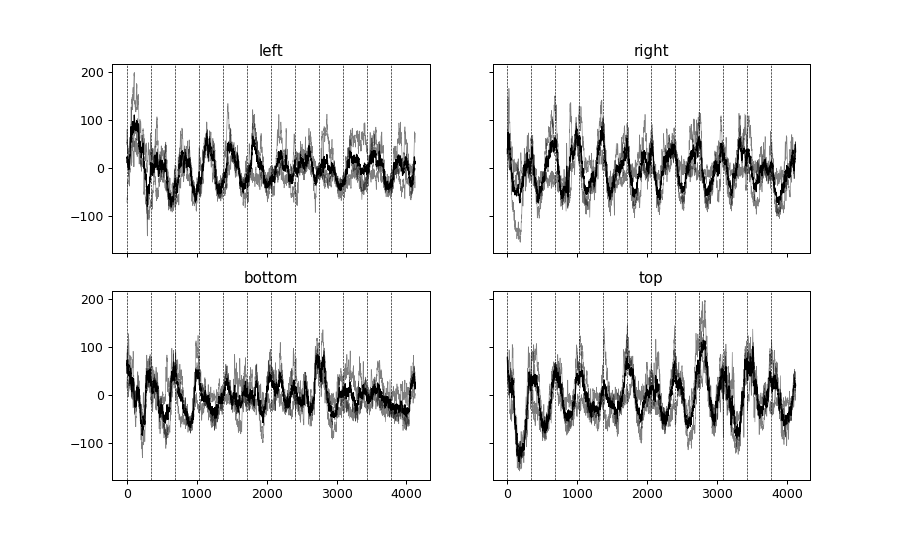

In [14]:
fig = rutils.plot_roi_traces_by_cond(roi_traces, stiminfo)


##### Find "rise" to fit Gaussian

<IPython.core.display.Javascript object>


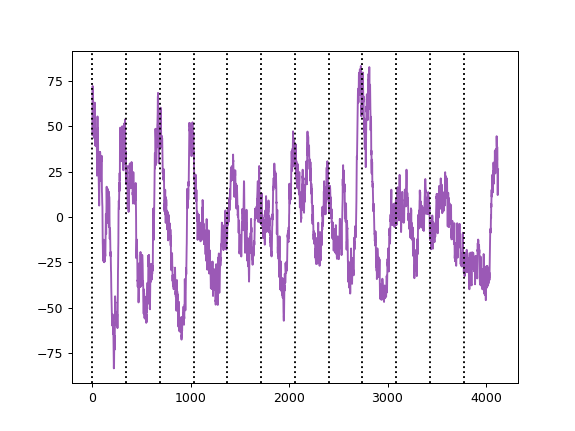

In [15]:
curr_trace = roi_traces[condition].mean(axis=0)
pl.figure()
pl.plot(curr_trace)
for cyc in stiminfo[condition]['cycle_start_ixs']:
    pl.axvline(x=cyc, color='k', linestyle=':')

In [18]:
window_nsecs = 0.5
nstds_above_baseline = 2

cycle_starts = stiminfo[condition]['cycle_start_ixs']
assert len(np.unique(np.diff(cycle_starts)))==1, "Uneven cycle durs found!"
fr_per_cyc = np.unique(np.diff(cycle_starts))[0]
baseline_window_size = int(round(stiminfo[condition]['frame_rate']*window_nsecs))

loci = {}
for condition, cond_traces in roi_traces.items():
    avg_trace = cond_traces.mean(axis=0)

    loci[cond] = get_cycle_onsets(avg_trace, cycle_starts, fr_per_cyc, \
                     baseline_window_size=baseline_window_size, nstds_above_baseline=nstds_above_baseline)

Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...
Getting new cmax...


In [19]:
np.diff([loc[0] for loc in loci[cond]['maxima']])

array([324, 358, 350, 316, 347, 402, 402, 256, 329, 345, 354])

In [20]:
sp.stats.sem(np.diff([loc[0] for loc in loci[cond]['maxima']]))

12.144175218413853

In [21]:
def lst_sq_fit(data, t, init_phase=0, init_freq=1, init_amp=1, use_cos=True):
    init_mean = np.mean(data)
    init_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    #guess_phase = sp.stats.circmean(corrected_phase[trials_by_cond[cond]].iloc[rid]) #0
    #guess_freq = 1 #1 #1
    #guess_amp = np.max(data) #1

    # we'll use this to plot our first estimate. This might already be good enough for you
    if use_cos:
        data_first_guess = init_std * np.cos(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.cos(x[1]*t+x[2]) + x[3] - data
    else:
        data_first_guess = init_std * np.sin(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data


    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    fit_amp, fit_freq, fit_phase, fit_mean = leastsq(optimize_func, [init_amp, init_freq, init_phase, init_mean])[0]

    # recreate the fitted curve using the optimized parameters
    if use_cos:
        data_fit = fit_amp*np.cos(fit_freq * t + fit_phase) + fit_mean
    else:
        data_fit = fit_amp*np.sin(fit_freq * t + fit_phase) + fit_mean

    params =  {'init_phase': init_phase,
              'init_amp': init_amp,
              'init_freq': init_freq,
              'fit_phase': fit_phase,
              'fit_amp': fit_amp,
              'fit_freq': fit_freq,
              'fit_mean': fit_mean,
              't': t}
    
    return data_fit, params #est_amp, est_freq, est_phase, est_mean



def fit_roi_trace(roi_data, roi_phases, t, use_cos=True): #, guess_phase=0, guess_freq=1, guess_amp=1):
    conditions = roi_data.columns.tolist()
    print conditions
    fit_results = {}
    for cond in conditions:
        print("fitting... %s" % cond)
        data = roi_data[cond].values #3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise
        init_phase = roi_phases[cond].values
        init_amp = np.max(data)
        init_freq = 1
        data_fit, params = lst_sq_fit(data, t, use_cos=use_cos, init_phase=init_phase, init_freq=init_freq, init_amp=init_amp)
        
        fit_results[cond] = {'fit': data_fit, 'params': params}
        
    return fit_results


In [22]:
from scipy.optimize import leastsq
from scipy.signal import argrelextrema


In [23]:

use_cos= True
fr = stiminfo[condition]['frame_rate']
n_frames = stiminfo[condition]['nframes']
stimfreq = stiminfo[condition]['stimfreq']
frame_period = 1./fr
t_frames = np.arange(frame_period, frame_period * (n_frames+1), frame_period)
print t_frames[0:5]
t = t_frames * (2*np.pi) * stimfreq

[ 0.022405    0.04480999  0.06721499  0.08961999  0.11202499]


In [24]:


roi_data = pd.concat((pd.Series(data=roi_traces[cond].mean(axis=0), name=cond)\
                      for cond in trials_by_cond.keys()), axis=1)
roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase[trialnums].iloc[rid], 
                                                            high=-np.pi, low=np.pi), 
                                     name=cond)) for cond, trialnums in trials_by_cond.items()).T

roi_fit = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)
peak_ixs = argrelextrema(roi_fit[condition]['fit'], np.greater)[0]
print "Found %i peaks. N frames per fit cycle:" % len(peak_ixs), np.diff(peak_ixs)

[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 345 344 344 345 344 345 344]


In [25]:
condition = 'right'
print roi_fit[condition].keys()
print roi_fit[condition]['params']

['params', 'fit']
{'fit_mean': -3.6969585633304827, 'fit_phase': 0.63688255117483517, 'init_amp': 86.340613893370218, 'fit_freq': 1.0054915589510114, 'init_freq': 1, 'init_phase': array([ 0.81551236]), 'fit_amp': 39.864614762324116, 't': array([  1.83007174e-02,   3.66014348e-02,   5.49021522e-02, ...,
         7.54538579e+01,   7.54721586e+01,   7.54904593e+01])}


<IPython.core.display.Javascript object>


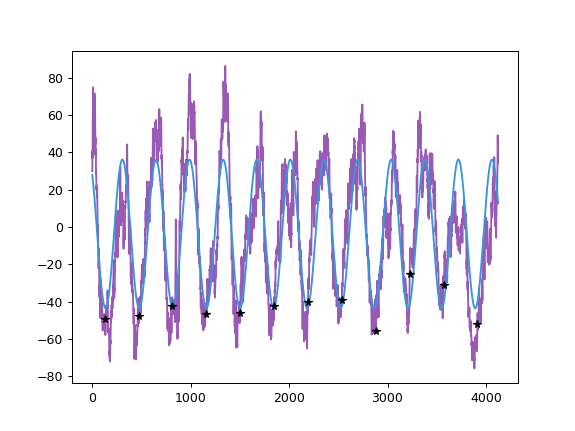

In [26]:
pl.figure()
pl.plot(roi_data[condition])
pl.plot(roi_fit[condition]['fit'])

for pix in peak_ixs:
    pl.plot(pix, roi_data[condition][pix], 'k*')

In [28]:
datestr = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates', datestr)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Saving figures to:\n", output_dir

Saving figures to:
/n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/visualization/rf_estimates/20190404202406


In [29]:
peak_centered_dir = os.path.join(output_dir, 'fit_centered_peaks')
if not os.path.exists(peak_centered_dir):
    os.makedirs(peak_centered_dir)
    
fit_traces_dir = os.path.join(output_dir, 'fit_trace_sinusoid')
if not os.path.exists(fit_traces_dir):
    os.makedirs(fit_traces_dir)
    

RID: 37
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 342 343 343 343 343 343 343 343 343 343]


<IPython.core.display.Javascript object>


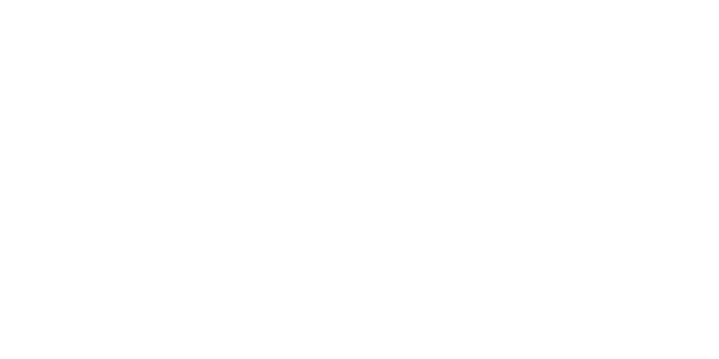

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 342 343 343 343 343 343 343 343 343 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 344 345 345 344 345 345 345 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 345 344 344 345 344 344 345 344 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 346 346 346 346 346 346 346 346]
RID: 55
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 343 343 343 343 342 343]


<IPython.core.display.Javascript object>


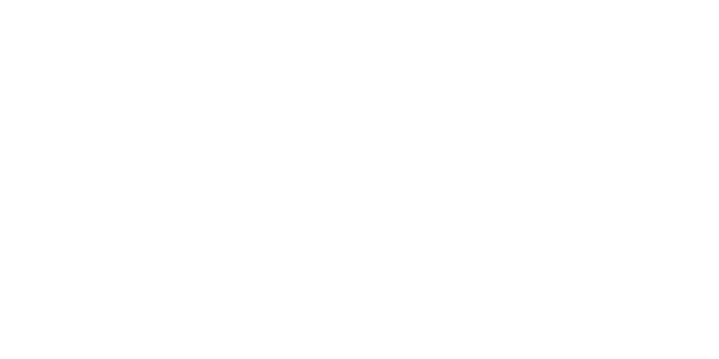

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 343 343 343 343 342 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 344 345 345 345 344 345 345 344 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 344 344 344 344 344 343 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 345 344 344 345 344 345 344]
RID: 3
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 344 345 344 344 345 344 344]


<IPython.core.display.Javascript object>


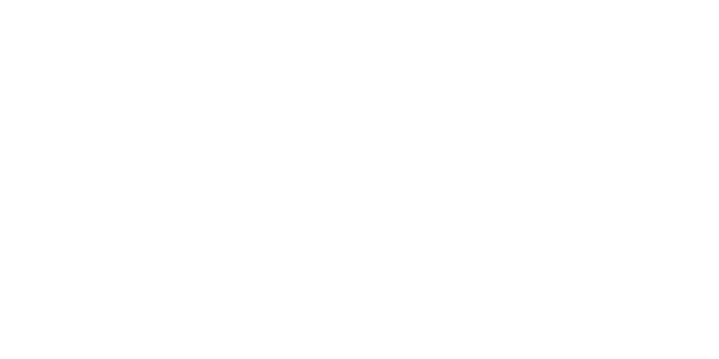

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 344 345 344 344 345 344 344]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 343 343 344 343 343 343 344 343 343 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [347 346 346 347 346 346 347 346 346 347 346]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [341 342 341 342 341 342 341 342 341 342 341]
RID: 42
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [340 340 340 340 340 339 340 340 340 340 340]


<IPython.core.display.Javascript object>


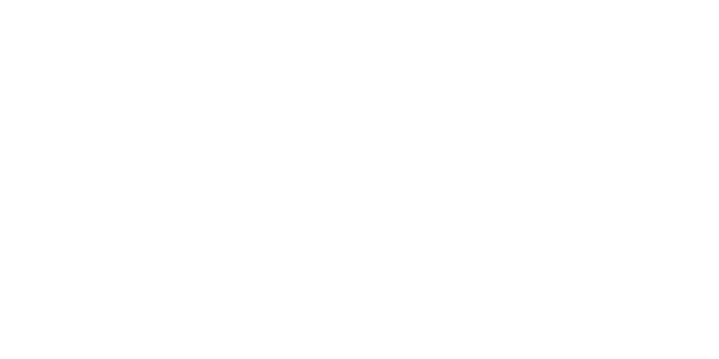

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [340 340 340 340 340 339 340 340 340 340 340]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 345 344 344 344 344 345 344 344 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 346 345 346 345 346 345 346 345 346]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 343 342 343 343 343 343]
RID: 28
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 347 346 346 346 346 347 346 346]


<IPython.core.display.Javascript object>


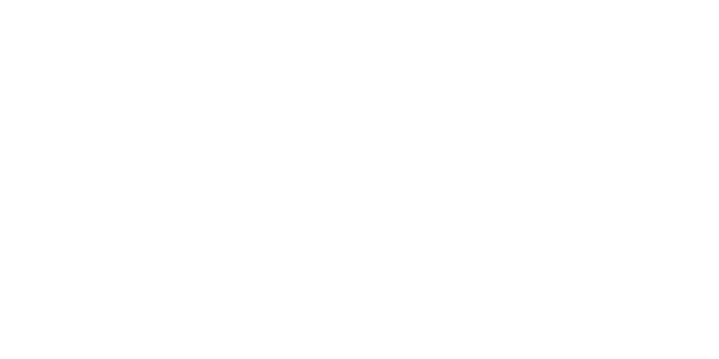

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 347 346 346 346 346 347 346 346]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 344 344 345 344 344 344 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [347 346 347 347 346 347 346 347 347 346 347]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 11 peaks. N frames per fit cycle: [346 346 346 346 346 346 346 346 346 346]
RID: 27
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 343 343 343 343 344 343]


<IPython.core.display.Javascript object>


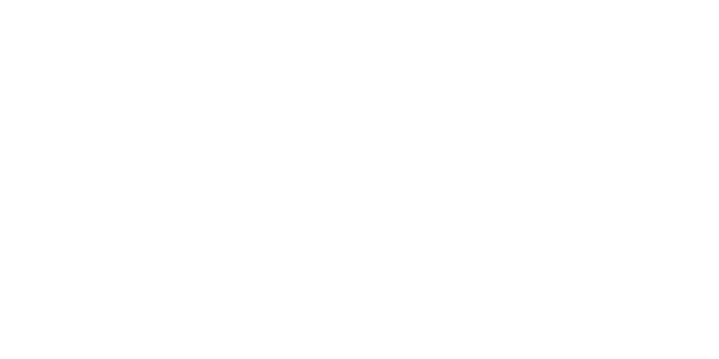

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 343 343 343 343 344 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 344 344 344 344 344 344 344 344 344 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 344 343 344 343 344 343 343 344 343 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 344 345 344 344 345 344 345 344 345 344]
RID: 77
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 343 343 344 343 344 343 343 344 343 344]


<IPython.core.display.Javascript object>


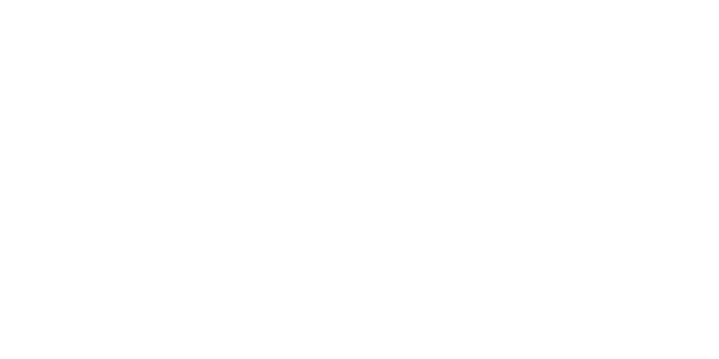

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 343 343 344 343 344 343 343 344 343 344]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 344 344 344 344 344 344 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 345 346 345 345 345 345 346 345]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 344 345 344 344 344 344 345]
RID: 36
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 346 345 345 345 345 346 345 345]


<IPython.core.display.Javascript object>


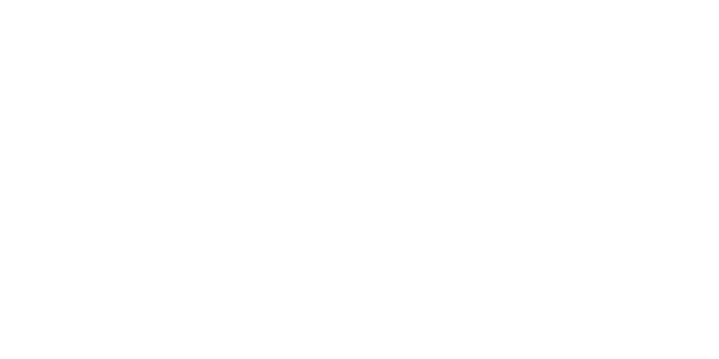

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 346 345 345 345 345 346 345 345]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 344 344 345 344 344 345 344 344 345 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 342 342 343 342 343 342 343 342 343]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 346 346 346 346 346 346 346 346]
RID: 80
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 344 344 344 344 344 344 345]


<IPython.core.display.Javascript object>


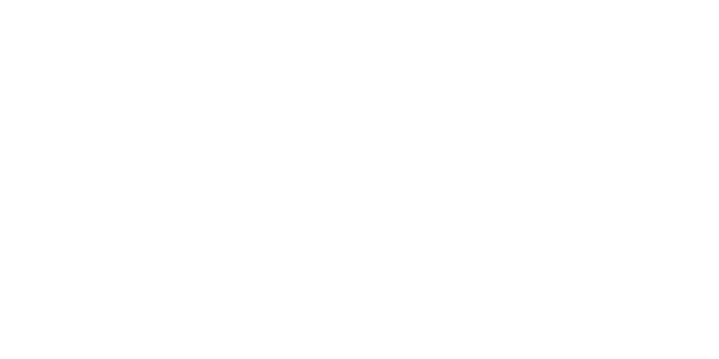

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 344 344 344 344 344 344 345]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 345 345 345 345 345 345 345 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 344 344 345 344 344 345 344 345 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [341 342 341 342 341 342 341 341 342 341 342]
RID: 63
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 342 343 343 343 342 343 343 343]


<IPython.core.display.Javascript object>


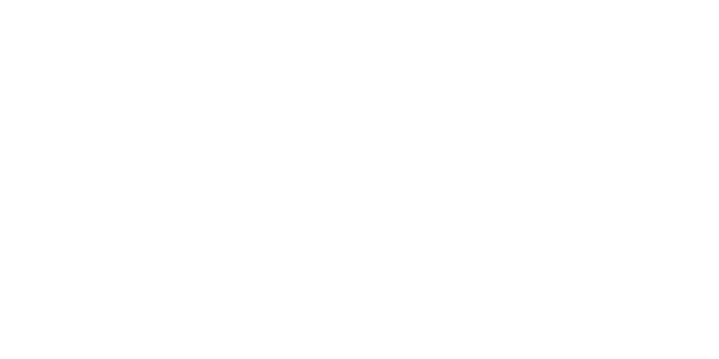

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 342 343 343 343 342 343 343 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 344 344 344 344 344 344 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 343 344 343 343 343 343 343]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 344 345 345 344 345 344 345 345 344]
RID: 26
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 345 345 345 345 345 345 346 345]


<IPython.core.display.Javascript object>


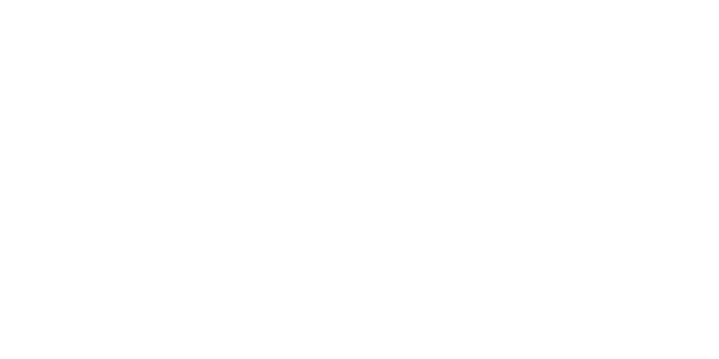

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 345 345 345 345 345 345 345 346 345]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 344 345 345 344 345 345 344 345 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 345 346 345 345 346 345 346 345 346]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 11 peaks. N frames per fit cycle: [345 346 345 346 345 345 346 345 346 345]
RID: 83
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [347 348 347 348 348 347 348 347 348 347 348]


<IPython.core.display.Javascript object>


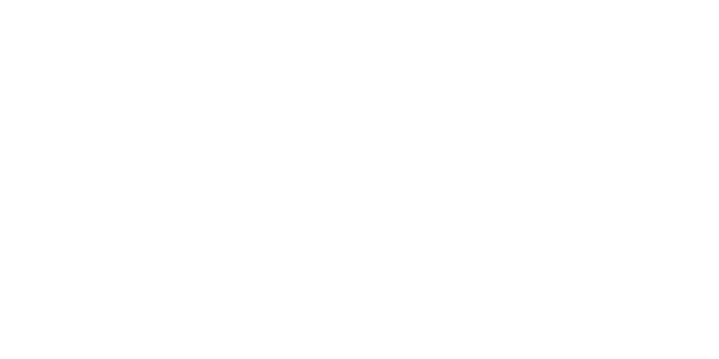

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [347 348 347 348 348 347 348 347 348 347 348]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 345 345 345 345 346 345 345 345 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 344 344 345 344 345 344 345 344 344 345]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 343 344 344 344 344 343 344]
RID: 53
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 342 343 343 342 343 343 343]


<IPython.core.display.Javascript object>


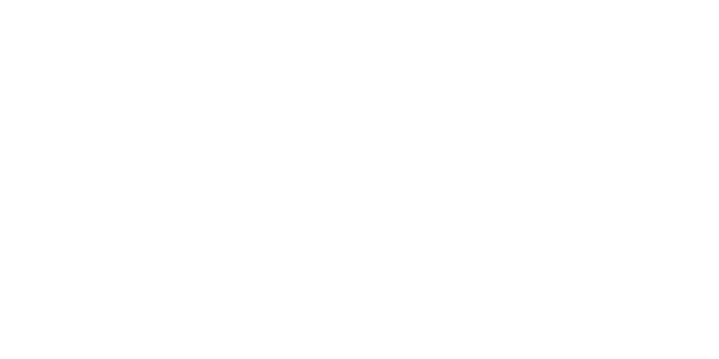

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 342 343 343 342 343 343 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 347 347 346 347 347 347 346 347 347 346]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 344 343 343 343 344 343 343 344 343 343]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 345 346 346 346 346 346 346 346 345 346]
RID: 46
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 346 345 346 345 346 345 345 346 345]


<IPython.core.display.Javascript object>


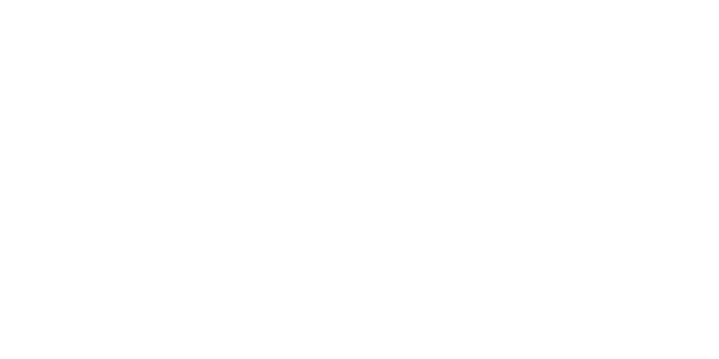

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 346 345 346 345 346 345 345 346 345]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 344 343 343 343 343 343 343 343 343]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 343 342 343 343 343 343 342 343]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 345 346 345 346 345 346 345 346 345]
RID: 19
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 342 343 343 343 342 343 343]


<IPython.core.display.Javascript object>


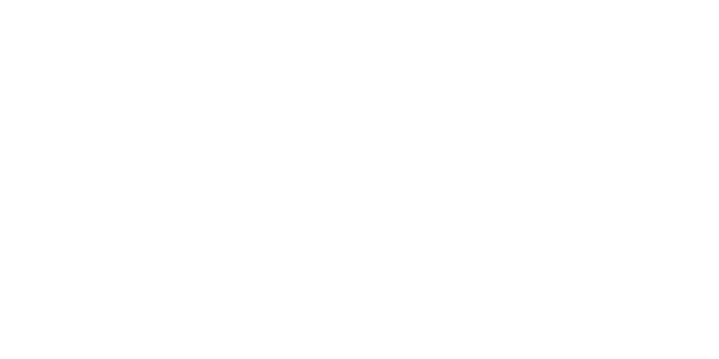

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 342 343 343 343 342 343 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 345 345 345 344 345 345 345 344 345 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 345 344 344 344 344 344 344 345 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 344 345 345 345 345 345 344 345 345 345]
RID: 97
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 346 347 346 346 346 346 347 346]


<IPython.core.display.Javascript object>


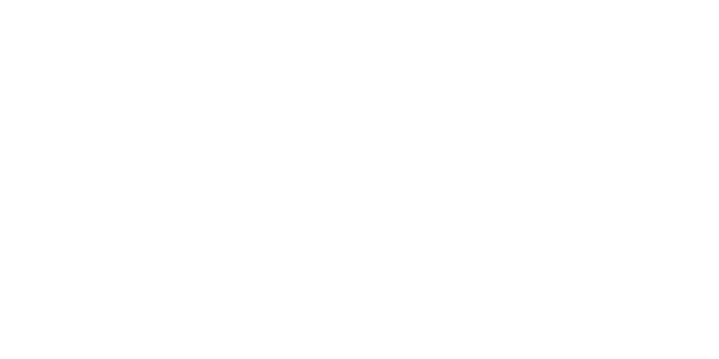

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [346 346 346 346 347 346 346 346 346 347 346]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 343 343 344 343 343 343 343 343 343 343]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [349 349 349 348 349 349 349 349 349 348 349]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 342 343 343 343 343 343 343 343 343 343]
RID: 13
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 343 342 343 343 343 343 343]


<IPython.core.display.Javascript object>


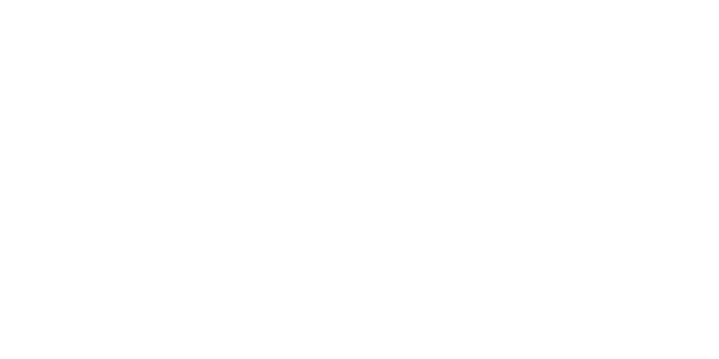

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [342 343 343 343 343 342 343 343 343 343 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 345 345 345 345 345 345 346 345 345]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 344 344 344 344 344 344 345 344 344 344]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 345 344 345 345 345 345 345 345 345 345]
RID: 107
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 343 343 344 343 343 344 343 343 344 343]


<IPython.core.display.Javascript object>


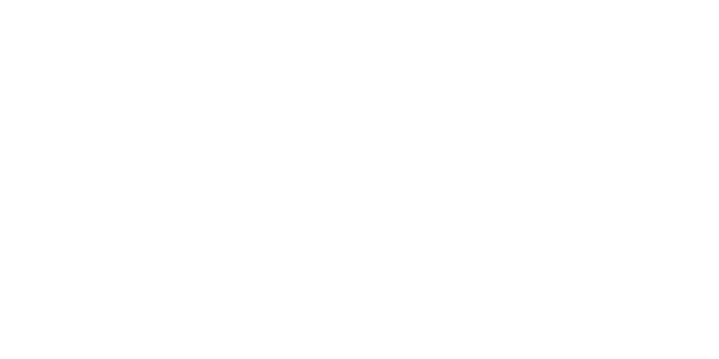

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [344 343 343 344 343 343 344 343 343 344 343]
top
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 344 345 345 344 345 345 344 345 345 344]
left
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 342 343 342 343 342 343 342 343 342 343]
right
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [345 346 346 346 346 345 346 346 346 346 345]
RID: 34
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 344 343 343 344 343 343 344 343 343 344]


<IPython.core.display.Javascript object>

bottom
[u'top', u'right', u'left', u'bottom']
fitting... top
fitting... right
fitting... left
fitting... bottom
Found 12 peaks. N frames per fit cycle: [343 344 343 343 344 343 343 344 343 343 344]


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [34]:
cond_colors = ['b', 'orange']

fits = dict((rid, dict()) for rid in sorted_top_rois)
for rid in sorted_top_rois:
    print "RID: %i" % rid

    roi_traces= dict()
    for condition in trials_by_cond.keys():
        roi_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
        #print"%s:" % condition, tmp_traces[condition].shape
        
    roi_data[rid] = pd.concat((pd.Series(data=roi_traces[cond].mean(axis=0), name=cond)\
                          for cond in trials_by_cond.keys()), axis=1)
    roi_phases[rid] = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase[trialnums].iloc[rid], 
                                                                high=-np.pi, low=np.pi), 
                                         name=cond)) for cond, trialnums in trials_by_cond.items()).T
    roi_trace_fit[rid] = fit_roi_trace(roi_data[rid], roi_phases[rid], t, use_cos=use_cos)
    
    peak_ixs = argrelextrema(roi_trace_fit[rid][condition]['fit'], np.greater)[0]
    print "Found %i peaks. N frames per fit cycle:" % len(peak_ixs), np.diff(peak_ixs)

#     fig, axes = pl.subplots(2,2)
#     for ax, condition in zip(axes.flat, roi_fit.keys()):

#         maxloc = max([roi_fit[condition]['fit'].max().max(), roi_data.max().max()])
#         plot_fit_by_condition(roi_fit[condition], data=roi_data,\
#                               color='k', fit_color='r', label='right', ax=ax, annot_loc=maxloc)
#         sns.despine(ax=ax, trim=True, offset=4)
#     fig.suptitle('roi #%i' % int(rid+1))


    
    fig, axes = pl.subplots(1, 2, figsize=(8,4))
    for condition in ['bottom', 'top', 'left', 'right']:
        ax = axes[0] if condition in ['left', 'right'] else axes[1]
        color = 'b' if condition in ['left', 'bottom'] else 'orange'

        print condition
        cycle_window = stiminfo[condition]['n_frames_per_cycle']*1.1
        centered_cycle = []

        curr_trace = roi_data[rid][condition]

        roi_fit = fit_roi_trace(roi_data[rid], roi_phases[rid], t, use_cos=use_cos)
        peak_ixs = argrelextrema(roi_fit[rid][condition]['fit'], np.greater)[0]
        print "Found %i peaks. N frames per fit cycle:" % len(peak_ixs), np.diff(peak_ixs)

        for pi, pix in enumerate(peak_ixs):
            if pi == 0:
                prev_start = 0
            start_ix = max([prev_start, pix-int(np.floor(cycle_window/2))])
            end_ix = min([len(curr_trace)-1, pix+int(np.floor(cycle_window/2))])

            curr_cycle_vals = curr_trace[start_ix:end_ix]

            if len(curr_cycle_vals) != cycle_window:
                desired_ix = pix-int(np.floor(cycle_window/2))
                if desired_ix < 0:
                    ixs_to_pad_front = abs(desired_ix)
                else:
                    ixs_to_pad_front = 0

                desired_ix = pix+int(np.floor(cycle_window/2))
                if desired_ix > len(curr_trace):
                    ixs_to_pad_tail = desired_ix - len(curr_trace) + 1
                else:
                    ixs_to_pad_tail = 0

                curr_cycle_vals = np.pad(curr_cycle_vals, (((ixs_to_pad_front, ixs_to_pad_tail),)),\
                                         mode='constant', constant_values=0)

            centered_cycle.append(curr_cycle_vals)
            prev_start = start_ix

        centered_cycles = np.vstack(centered_cycle)

        #[i.shape for i in centered_cycle]
        centered_cycle_avg = centered_cycles.mean(axis=0)
        if centered_cycle_avg.min() < 0:
            centered_cycle_avg -= centered_cycle_avg.min()

        roi_cycle_fit = fit_gaussian_to_trace(centered_cycle_avg)

        ax.plot(centered_cycle_avg, color=color, linestyle=':', label=condition)
        if fit_results['y_fit'] is not None:
            ax.plot(fit_results['y_fit'], color=color, label='fit (r2=%.2f)' % fit_results['r2'])

        fits[rid][condition] = {'centered_fit': fit_results,
                                'centered_cycle': centered_cycles,
                                'trace_fit': roi_fit,
                                'peak_ixs': peak_ixs}

        #ax.legend()
        ax.legend(bbox_to_anchor=(0.9, 1), fontsize=8)
        sns.despine(offset=4, trim=True, ax=ax)

    pl.subplots_adjust(top=0.8, wspace=0.5, left=0.1, right=0.8)
    fig.suptitle('roi #%i' % int(rid+1))
    label_figure(fig, data_identifier)
    figname = 'peak_centered_gauss_roi%05d' % int(rid+1)
    pl.savefig(os.path.join(peak_centered_dir, '%s.png' % figname))
    pl.close()
    

# Also save fit sinusoids:


In [64]:

def plot_fit_by_condition(fit_results, data=None, color='k', fit_color=None, label='label', ax=None, annot_loc=0):
    if ax is None:
        fig, ax = pl.subplots()

    
    #fig, ax = pl.subplots(1, 2, figsize=(15,5)) # = pl.figure()
    if data is not None:
        ax.plot(fit_results['params']['t'], data, color=color, lw=0.5, alpha=0.7)
    
    if fit_color is None:
        fit_color = color
    #data_fit = fit_results['fit_amp'] * np.sin(fit_results['fit_freq'] * fit_t + fit_results['fit_phase']) + fit_results['fit_mean']
    data_fit = fit_results['fit']
    ax.plot(fit_results['params']['t'], data_fit, color=fit_color, label=label)
    
    #cond_str = "[%s] True: %.2f, Est: %.2f" % (label, fit_results['params']['init_phase'], fit_results['params']['fit_phase'])
    #ax.text(ax.get_xlim()[0], annot_loc, cond_str) #ax.get_ylim()[-1]-100, cond_str)
    #ax.legend(loc='lower right')
    
    return ax

<IPython.core.display.Javascript object>


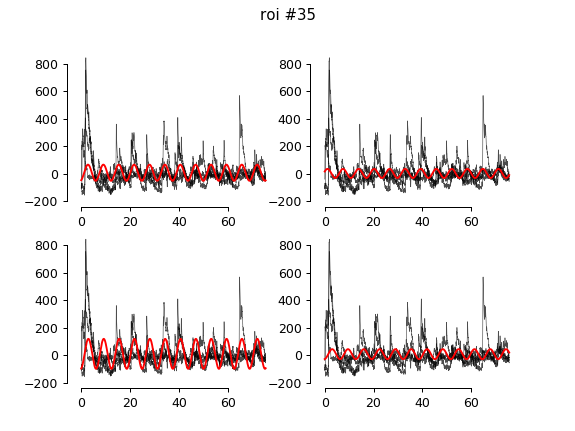

Text(0.5,0.98,u'roi #35')

In [66]:
fig, axes = pl.subplots(2,2)
for ax, condition in zip(axes.flat, roi_fit.keys()):

    maxloc = max([roi_fit[condition]['fit'].max().max(), roi_data.max().max()])
    plot_fit_by_condition(roi_fit[condition], data=roi_data,\
                          color='k', fit_color='r', label='right', ax=ax, annot_loc=maxloc)
    sns.despine(ax=ax, trim=True, offset=4)
fig.suptitle('roi #%i' % int(rid+1))

In [50]:
roi_fit['top']

{'fit': array([-46.1637663 , -45.74949283, -45.31715993, ..., -48.08936237,
        -47.77522533, -47.44235289]),
 'params': {'fit_amp': 58.871896896546524,
  'fit_freq': 0.99819250094749234,
  'fit_mean': 8.3696819976994732,
  'fit_phase': -2.7735537763568194,
  'init_amp': 756.66578215790821,
  'init_freq': 1,
  'init_phase': array([-2.75019517]),
  't': array([  1.83007174e-02,   3.66014348e-02,   5.49021522e-02, ...,
           7.54538579e+01,   7.54721586e+01,   7.54904593e+01])}}

In [171]:

fitness_thr = 0.6
size_thr = 0.1
borders = estimate_RF_size(fit_results, fitness_thr=fitness_thr, size_thr=size_thr)

print rf_width_frames

deg_per_cycle = stim_positions['left'].iloc[-1, :].mean() - stim_positions['left'].iloc[0, :].mean()

frames_per_degree = stiminfo[condition]['n_frames_per_cycle'] / deg_per_cycle

print rf_width_frames*frames_per_degree


209
785.63364208


In [162]:
stim_positions['left'].iloc[0, :].mean()
stim_positions['left'].iloc[-1, :].mean()

47.532109650700058

In [200]:
stiminfo[condition]['n_frames_per_cycle'] 

343

In [199]:
deg_per_cycle

91.247365388004738

In [32]:
def fit_gaussian_to_trace(parsed_trace):
    fit_results = {}
    
    x0 = np.arange(0,len(parsed_trace))
    y = parsed_trace #-y0.min()
    try:
        center_start = np.argmax(y)-(np.argmax(y)/1)
        center_end = np.argmax(y)+(np.argmax(y)/1)*2
        if center_start < 0:
            center_start = 0
        if center_end > len(y):
            center_end = len(y)
        centered = y[np.arange(center_start, center_end)]
        popt, pcov = curve_fit(gaus, x0, y, p0=(y[np.argmax(y)], np.argmax(y), 1))

        y_fit = gaus(x0,*popt)
        #print(popt)

        ss_res = np.sum((y - y_fit)**2)
        ss_tot = np.sum((y-np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)
        #assert r_squared >= 0, "R2 is negative..."
        #print("R2:", r_squared)
        A, x0, sigma = popt

    except RuntimeError:
        print("Error - curve_fit failed")
        A = None; x0 = None; sigma = None;
        r_squared = 0
        y_fit = None
    
    fit_results = {'r2': r_squared,
                   'A': A,
                   'x0': x0,
                   'sigma': sigma,
                   'y_fit': y_fit,
                   'y': y}
    
    return fit_results


def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


def estimate_RF_size(fit_results, fitness_thr=0.5, size_thr=0.1):

    if fit_results['r2'] > fitness_thr:

        y = fit_results['y']
        y_fit = fit_results['y_fit']

        fit_norm = y_fit/np.max(y_fit)

        border_start = np.where(fit_norm>=size_thr)[0]
        if len(border_start)==0:
            border_start = 0
        else:
            border_start = border_start[0]
        border_end = np.where(fit_norm[border_start:]<=size_thr)[0]
        if len(border_end) == 0:
            border_end = len(fit_norm)-1
        else:
            border_end = border_end[0]

        # extrapolate around peak, in case edge:
#         peak = np.argmax(y)
#         tail2 = border_end - peak
#         tail1 = peak - border_start
#         if tail1 < tail2:
#             border_edge1 = peak - tail2
#             border_edge2 = peak + tail2
#         elif tail2 < tail1:
#             border_edge2 = peak + tail1
#             border_edge1 = peak - tail1
#         else:
#             border_edge1 = peak - tail1
#             border_edge2 = peak + tail2

#         rf_size_frames = border_edge2 - border_edge1
    else:
        rf_size_frames = 0
        peak = 0
        border_start = 0; border_end = 0

    borders = (border_start, border_end)
    rf_width_frames = border_end - border_start
    
    return borders
        

<IPython.core.display.Javascript object>


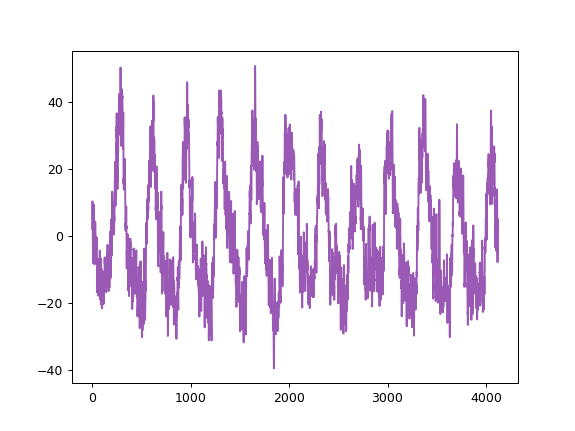

In [113]:
pl.figure()
pl.plot(vals)